In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [77]:
import cmocean

In [3]:
import graphufs

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [23]:
from p1stacked import P1Emulator
p1 = P1Emulator()

In [4]:
plt.style.use("graphufs.plotstyle")

In [5]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [6]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [7]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [8]:
gds = open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr/")

In [40]:
era = xr.open_zarr("gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr", storage_options={"token": "anon"})
era = era.sel(time=slice(p1.validation_dates[0], p1.validation_dates[1]))
era = era.sel(level=[100, 500, 850])

In [41]:
gds["speed"] = np.sqrt(gds["ugrd10m"]**2 + gds["vgrd10m"]**2)
era["speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

In [125]:
def spatial_map(gda, tda, itime, fhr, vmax=None, vmin=None, cmap=None):
    
    t0 = gda.time.isel(time=itime).values
    date = t0 + pd.Timedelta(f"{fhr}h")
    
    fig, axs = plt.subplots(
        1,2,
        figsize=(10, 6),
        constrained_layout=True,
        subplot_kw={
            "projection": ccrs.Orthographic(
                central_longitude=-80,
                central_latitude=20,
            ),
        },
    )
    if vmax is None:
        if gda.name == "tmp2m":
            vmax = 30
        elif "speed" in gda.name:
            vmax = 25
    if vmin is None:
        if gda.name == "tmp2m":
            vmin = -10
        elif "speed" in gda.name:
            vmin = 0

    if cmap is None:
        if gda.name == "tmp2m":
            cmap = "cmo.thermal"
        elif "speed" in gda.name:
            cmap = "cmo.speed"
    
    kw = {
        "transform": ccrs.PlateCarree(),
        "cmap": cmap,
        "vmax": vmax,
        "vmin": vmin,
        "add_colorbar": False, 
    }

    if gda.name == "tmp2m":
        gda = gda - 273.15
        tda = tda - 273.15

    p = gda.isel(time=itime).sel(fhr=fhr).plot(ax=axs[0], **kw)
    tda.sel(time=date).plot(ax=axs[1], x="longitude", **kw)
    
    [ax.add_feature(cf.COASTLINE) for ax in axs];
    axs[0].set(title=f"GraphUFS, {str(t0)[:13]} + 24h")
    axs[1].set(title=f"ERA5, {str(date)[:13].replace(' ', 'T')}");
    fig.colorbar(p, ax=axs, orientation="horizontal", shrink=.6, aspect=35, label="2m Temperature ($^\circ$C)", extend="both")
    return fig, axs

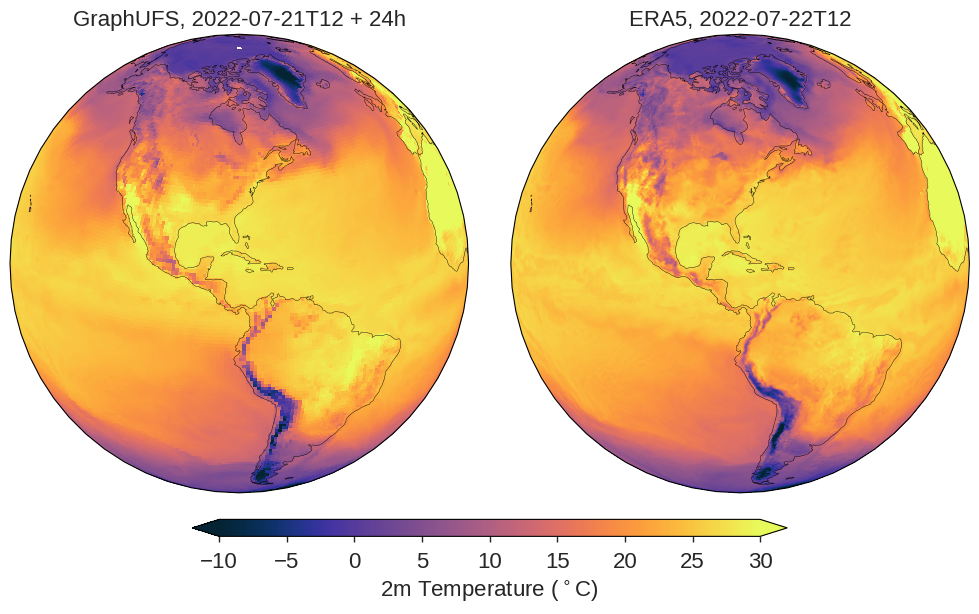

In [126]:
fig, axs = spatial_map(gds["tmp2m"], era["2m_temperature"], itime=179, fhr=24)
fig.savefig(f"figures/graphufs_and_era5_tmp2m_24h.jpeg", bbox_inches="tight", dpi=300)

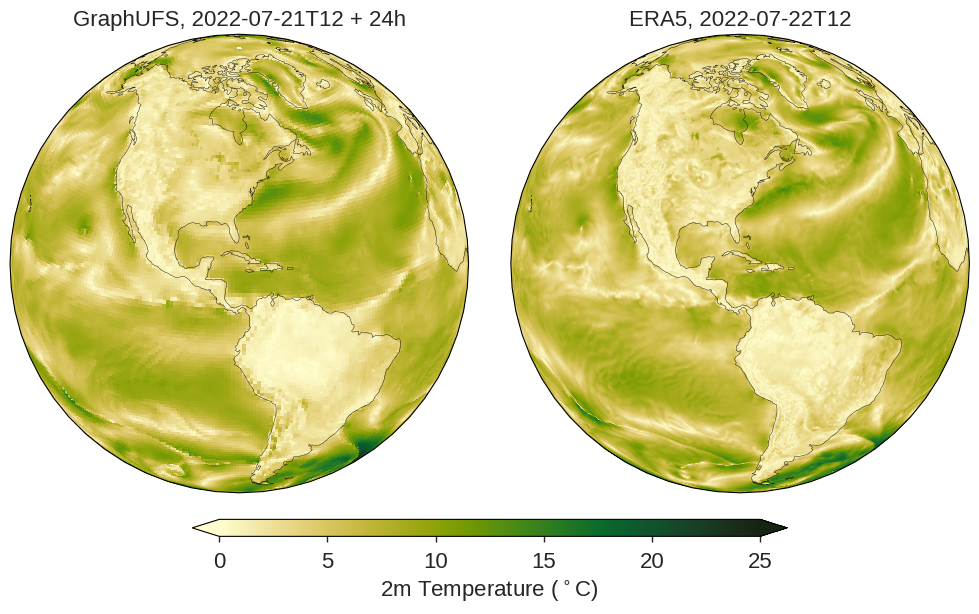

In [128]:
fig, axs = spatial_map(gds["speed"], era["speed"], itime=179, fhr=24)
fig.savefig(f"figures/graphufs_and_era5_windspeed_24h.jpeg", bbox_inches="tight", dpi=300)